In [1]:
%matplotlib inline
from collections import defaultdict

import matplotlib.pylab as plt
from skimpy import skim
import numpy as np
import pandas as pd
from IPython.display import display, HTML
import seaborn as sns

from tqdm import tqdm

from pathlib import Path
import importlib


In [2]:

import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_probability.python.bijectors as tfb

from bayesianquilts.models.logistic_regression import LogisticRegression
from bayesianquilts.metrics.classification import classification_metrics
from bayesianquilts.sampler import psis, nppsis

2024-12-03 15:58:35.942252: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-03 15:58:35.945334: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-03 15:58:35.954729: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733241515.970588 1351379 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733241515.976184 1351379 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 15:58:35.993813: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [3]:
print(tf.__version__, tfp.__version__)

2.18.0 0.25.0


# Load the dataset

Using the example from here: https://www.tensorflow.org/guide/core/logistic_regression_core

In [6]:
#!pip install ucimlrepo
from ucimlrepo import fetch_ucirepo 


In [7]:
dataset = "ovarian"
# dataset = "breast"
use_saved = False

if dataset == "breast":
    # fetch dataset 
    cdc_diabetes_health_indicators = fetch_ucirepo(id=891) 
  

    # data (as pandas dataframes) 
    batch_size=151
    X = cdc_diabetes_health_indicators.data.features
    y = cdc_diabetes_health_indicators.data.targets

    X = X.fillna(0)
    batch_size=300
    
else:
    X = pd.read_csv(f"{importlib.resources.path('bayesianquilts', 'data')}/overianx.csv", header=None)
    y = pd.read_csv(f"{importlib.resources.path('bayesianquilts', 'data')}/overiany.csv", header=None)
    batch_size = 6

X_scaled = (X - X.mean())/X.std()
X_scaled = X_scaled.fillna(0)
n = X_scaled.shape[0]
p = X_scaled.shape[1]

print((n, p))


(54, 1536)


In [6]:


tfdata = tf.data.Dataset.from_tensor_slices({'X': X_scaled, 'y':y})

def data_factory_factory(batch_size=batch_size, repeat=False, shuffle=False):
    def data_factory(batch_size=batch_size):
        if shuffle:
            out = tfdata.shuffle(batch_size*10)
        else:
            out = tfdata
        
        if repeat:
            out = out.repeat()
        return out.batch(batch_size)
    return data_factory

Instantiate the model object

In [7]:
if not use_saved:

    if dataset == "ovarian":
        guessnumrelevcov = 20.0
        slab_scale = 2.5
        scale_icept = 5.0
        nu_global = 1
        nu_local = 1
        slab_df = 1
        scale_global = guessnumrelevcov/((p - guessnumrelevcov)*np.sqrt(n))
        lr_model = LogisticRegression(dim_regressors=p, global_horseshoe_scale=scale_global)
        print(scale_global)
    else:
        lr_model = LogisticRegression(dim_regressors=p, global_horseshoe_scale=1.)
        
else:
    import dill as pickle
    import gzip
    if dataset == 'ovarian':
        with gzip.open("ovarian_gwas.gz", 'rb') as f:
            lr_model = pickle.load(f)
    else:
        with gzip.open("breast.gz", 'rb') as f:
            lr_model = pickle.load(f)

0.0017952871172553341


# MCMC inference

In [8]:
all_data = next(iter(data_factory_factory(batch_size=54)()))

In [9]:


num_results = 2000
num_burnin_steps = 6000
num_leapfrog_steps = 10
var_labels = list(lr_model.surrogate_distribution.model.keys())

initial = lr_model.sample(1)
initial = [initial[k] for k in var_labels]

def unormalized_log_prob(*params):
    return lr_model.unormalized_log_prob(all_data, **{k: p for k, p in zip(var_labels, params)})
    
hcm_kernel  = tfp.mcmc.HamiltonianMonteCarlo(
  target_log_prob_fn=unormalized_log_prob,
  step_size=1e-4,
  num_leapfrog_steps=num_leapfrog_steps
  
)

hcm_kernel = tfp.mcmc.NoUTurnSampler(
    unormalized_log_prob,
    1e-4,
    max_tree_depth=15,
    max_energy_diff=100.0,
    unrolled_leapfrog_steps=num_leapfrog_steps,
    parallel_iterations=10,
    experimental_shard_axis_names=None,
    name=None
)

# This adapts the inner kernel's step_size.
adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
  inner_kernel = hcm_kernel,
  num_adaptation_steps=int(num_burnin_steps * 0.8)
)
pbar = tfp.experimental.mcmc.ProgressBarReducer(num_results)
adaptive_hmc = tfp.experimental.mcmc.WithReductions(
    adaptive_hmc, pbar
)

@tf.function(autograph=False)
def do_sampling():
  out = tfp.experimental.mcmc.sample_chain_with_burnin(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      num_steps_between_results=1,
      current_state=initial,
      kernel=adaptive_hmc,
      # reducer=pbar,
      parallel_iterations=12,
      )
  return out[0]

result = do_sampling()


100%|██████████| 2000/2000 [18:16:41<00:00, 32.90s/it]   


In [ ]:
params = {k: t[(-1024)::4, 0, ...] for k, t in zip(var_labels, result)}


Set up Bayesian minibatch ADVI inference

9it [00:00, 214.58it/s]


(0.0, 1.0)

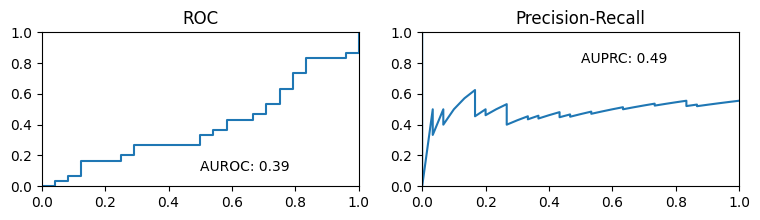

In [ ]:
def prediction_fn(data):
    pred = lr_model.predictive_distribution(data, **params)["logits"]
    return tf.reduce_mean(pred, axis=0)

bench = classification_metrics(
    data_factory=data_factory_factory(),
    prediction_fn=prediction_fn,
    outcome_label='y',
    by_vars=[]
)

fig, ax = plt.subplots(1, 2, figsize=(9, 2))
ax[0].plot(bench['auroc']['fpr'], bench['auroc']['tpr'])
ax[0].text(0.5, 0.1, f"AUROC: {round(bench['auroc']['auroc'], 2)}")
ax[0].set_xlim((0, 1))
ax[0].set_ylim((0, 1))
ax[0].set_title("ROC")

ax[1].plot(bench['auprc']['recall'], bench['auprc']['precision'])
ax[1].text(0.5, 0.8, f"AUPRC: {round(bench['auprc']['auprc'], 2)}")
ax[1].set_title("Precision-Recall")
ax[1].set_xlim((0, 1))
ax[1].set_ylim((0, 1))

In [ ]:
if dataset == "ovarian":
    test_batch = next(iter(data_factory_factory(batch_size=56, shuffle=False)()))
else:
    test_batch = next(iter(data_factory_factory()()))


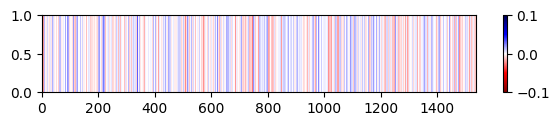

In [ ]:
beta = tf.reduce_mean(params['beta__'], axis=0)
fig, ax = plt.subplots(1, 1, figsize=(7, 1 ))
im = ax.pcolormesh(beta, vmin=-.1, vmax=.1, cmap='seismic_r')
plt.colorbar(im)

In [ ]:
def adaptive_is_loo(self, data, params, hbar=1.0, variational=True):
    """_summary_

    Args:
        data (_type_): _description_
        params (_type_): _description_
        hbar (float, optional): _description_. Defaults to 1.0.
        variational (bool, optional):
            Should we trust the variational approximation?
            If False, assumes that one is passing in all the data at once in a single batch.
            Defaults to True.

    Returns:
        _type_: _description_
    """

    # scaled (theta - bar(theta))/Sigma
    beta = params["beta__"]
    intercept = params["intercept__"]
    X = tf.cast(data["X"], self.dtype)
    y = tf.squeeze(tf.cast(data["y"], self.dtype))
    mu = tf.reduce_sum(beta * X, axis=-1) + intercept[..., 0]
    sigma = tf.math.sigmoid(mu)
    ell = y * (sigma) + (1 - y) * (1 - sigma)
    log_ell = tf.math.xlogy(y, sigma) + tf.math.xlogy(1 - y, 1 - sigma)
    log_ell_prime = y * (1 - sigma) - (1 - y) * sigma
    log_ell_doubleprime = -sigma * (1 - sigma)

    """
    sigma.shape is samples x datapoints
    """

    # compute # \nabla\log\pi(\btheta|\calD)
    if variational:
        # \nabla\log\pi = -\Sigma^{-1}(theta - \bar{\theta})
        grad_log_pi = tf.concat(
            [
                -(intercept - self.surrogate_distribution.model["intercept__"].mean())
                / self.surrogate_distribution.model["intercept__"].variance(),
                -(beta - self.surrogate_distribution.model["beta__"].mean())
                / self.surrogate_distribution.model["beta__"].variance(),
            ],
            axis=-1,
        )
        intercept_sd = (
            self.surrogate_distribution.model["intercept__"].variance() ** 0.5
        )
        beta_sd = self.surrogate_distribution.model["beta__"].variance() ** 0.5

        log_pi = self.surrogate_distribution.model["beta__"].log_prob(
            params["beta__"]
        ) + self.surrogate_distribution.model["intercept__"].log_prob(
            params["intercept__"]
        )
        log_pi -= tf.reduce_max(log_pi, axis=0)
    else:
        """
        Recall Bayes rule:
        \log pi(\btheta|\calD) = \sum_i\log ell_i(\btheta) + \log\pi(\btheta) + const

        so
        \nabla\log\pi(\btheta|\calD) = \sum_i (ell_i)'x + grad\log\pi(\btheta)

        """
        log_pi = tf.reduce_sum(log_ell, axis=1, keepdims=True)[:, 0]
        log_pi += self.prior_distribution.log_prob(
            {
                "regression_model": {
                    k: tf.cast(params[k], self.dtype) for k in self.regression_var_list
                },
                "intercept_model": {
                    k: tf.cast(params[k], self.dtype) for k in self.intercept_var_list
                },
            }
        )
        # pi \propto
        grad_log_pi = tf.reduce_sum(
            log_ell[..., tf.newaxis] * X, axis=1, keepdims=True
        )  # TODO NEED PRIOR TERM

        prior_intercept_sd = (
            self.prior_distribution.model["intercept_model"]
            .model["intercept__"]
            .variance()
            ** 0.5
        )
        prior_beta_sd = params["global_scale"]

        intercept_sd = tf.math.reduce_std(intercept, 0, keepdims=True)
        beta_sd = tf.math.reduce_std(beta, 0, keepdims=True)

    # log-likelihood descent

    def T_ll():
        Q_beta = -log_ell_prime[..., tf.newaxis] * X
        Q_intercept = -log_ell_prime[..., tf.newaxis]

        standardized = tf.concat(
            [Q_beta / beta_sd, Q_intercept / intercept_sd], axis=-1
        )
        standardized = tf.reduce_max(tf.math.abs(standardized), axis=-1)
        standardized = tf.reduce_max(standardized, axis=0, keepdims=True)[
            ..., tf.newaxis
        ]

        h = hbar / standardized
        logJ = tf.math.log1p(
            tf.math.abs(
                h
                * (1 + tf.math.reduce_sum(X**2, -1, keepdims=True))[tf.newaxis, :, :]
                * (sigma * (1 - sigma))[..., tf.newaxis]
            )[..., 0]
        )
        beta_ll = beta + h * Q_beta
        intercept_ll = intercept + h * Q_intercept
        return beta_ll, intercept_ll, logJ

    def T_kl():

        Q_beta = ((-1) ** y * tf.math.exp(log_pi[..., tf.newaxis] + mu * (1 - 2 * y)))[
            ..., tf.newaxis
        ] * data["X"]
        Q_intercept = (
            (-1) ** y * tf.math.exp(log_pi[..., tf.newaxis] + mu * (1 - 2 * y))
        )[..., tf.newaxis]

        dQ = (
            (-1) ** y[tf.newaxis, :]
            * tf.math.exp(log_pi[..., tf.newaxis] + mu * (1 - 2 * y[tf.newaxis, :]))
            * (
                grad_log_pi[..., 0]
                + (1 - 2 * y)[tf.newaxis, :]
                + tf.reduce_sum(
                    X * (grad_log_pi[..., 1:] + (1 - 2 * y)[:, tf.newaxis] * X), axis=-1
                )
            )
        )

        standardized = tf.concat(
            [Q_beta / beta_sd, Q_intercept / intercept_sd], axis=-1
        )
        standardized = tf.reduce_max(tf.math.abs(standardized), axis=-1)
        standardized = tf.reduce_max(standardized, axis=0, keepdims=True)[
            ..., tf.newaxis
        ]

        h = hbar / standardized

        intercept_kl = intercept + h * Q_intercept
        beta_kl = beta + h * Q_beta

        logJ = tf.math.log1p(tf.math.abs(h[..., 0] * dQ))
        return beta_kl, intercept_kl, logJ

    # variance descent -(log ell)'/l

    def T_I():
        Q = tf.zeros_like(log_ell)
        return (
            beta + Q[..., tf.newaxis],
            intercept + Q[..., tf.newaxis],
            tf.zeros_like(Q),
        )

    def T_var():

        Q_beta = (
            (-1) ** y * tf.math.exp(log_pi[..., tf.newaxis] + 2 * mu * (1 - 2 * y))
        )[..., tf.newaxis] * data["X"]
        Q_intercept = (
            (-1) ** y * tf.math.exp(log_pi[..., tf.newaxis] + 2 * mu * (1 - 2 * y))
        )[..., tf.newaxis]

        dQ = (
            (-1) ** y[tf.newaxis, :]
            * tf.math.exp(log_pi[..., tf.newaxis] + 2 * mu * (1 - 2 * y[tf.newaxis, :]))
            * (
                grad_log_pi[..., 0]
                + (1 - 2 * y)[tf.newaxis, :]
                + tf.reduce_sum(
                    X * (grad_log_pi[..., 1:] + 2 * (1 - 2 * y)[:, tf.newaxis] * X),
                    axis=-1,
                )
            )
        )

        standardized = tf.concat(
            [Q_beta / beta_sd, Q_intercept / intercept_sd], axis=-1
        )
        standardized = tf.reduce_max(tf.math.abs(standardized), axis=-1)
        standardized = tf.reduce_max(standardized, axis=0, keepdims=True)[
            ..., tf.newaxis
        ]

        h = hbar / standardized

        intercept_kl = intercept + h * Q_intercept
        beta_kl = beta + h * Q_beta

        logJ = tf.math.log1p(tf.math.abs(h[..., 0] * dQ))
        return beta_kl, intercept_kl, logJ

    def IS(Q):
        beta_new, intercept_new, logJ = Q()
        mu_new = tf.reduce_sum(beta_new * X, axis=-1) + intercept_new[..., 0]
        sigma_new = tf.math.sigmoid(mu_new)
        ell_new = y * (sigma_new) + (1 - y) * (1 - sigma_new)
        log_ell_new = tf.math.xlogy(y, sigma_new) + tf.math.xlogy(1 - y, 1 - sigma_new)
        transformed = params.copy()
        transformed["beta__"] = beta_new[..., tf.newaxis, :]
        transformed["intercept__"] = intercept_new[..., tf.newaxis, :]
        transformed["global_scale"] = transformed["global_scale"][..., tf.newaxis, :]
        transformed["global_scale_aux"] = transformed["global_scale_aux"][
            ..., tf.newaxis, :
        ]

        if variational:
            # We trust the variational approximation, so \hat{pi} = pi
            # N_samples x N_data
            delta_log_pi = (
                self.surrogate_distribution.log_prob(transformed)
                - log_pi[:, tf.newaxis]
            )
            delta_log_pi = delta_log_pi - tf.reduce_max(
                delta_log_pi, axis=0, keepdims=True
            )
            pass
        else:
            # we don't trust the variational approximation
            # Need to compute log_pi directly by summing over the likelihood

            ell_cross = (
                tf.reduce_sum(beta_new[..., tf.newaxis, :] * data["X"], -1)
                + intercept_new
            )
            ell_cross = tf.reduce_sum(
                ell_cross, -1
            )  # this is the likelihood portion of pi(T(theta))

            log_pi_new = self.prior_distribution.log_prob(
                {
                    "regression_model": {
                        k: tf.cast(transformed[k], self.dtype)
                        for k in self.regression_var_list
                    },
                    "intercept_model": {
                        k: tf.cast(transformed[k], self.dtype)
                        for k in self.intercept_var_list
                    },
                }
            )[:, tf.newaxis]
            log_pi_new += ell_cross
            # Incorporate the prior
            delta_log_pi = log_pi_new - log_pi[:, tf.newaxis]
            delta_log_pi = delta_log_pi - tf.reduce_max(
                delta_log_pi, axis=0, keepdims=True
            )

        log_eta_weights = delta_log_pi - log_ell_new + logJ
        psis_weights, khat = nppsis.psislw(log_eta_weights)
        
        eta_weights = tf.math.exp(log_eta_weights)
        eta_weights = eta_weights / tf.reduce_sum(eta_weights, axis=0, keepdims=True)

        psis_weights = tf.math.exp(psis_weights)
        psis_weights = psis_weights / tf.math.reduce_sum(
            psis_weights, axis=0, keepdims=True
        )

        weight_entropy = self.entropy(eta_weights)
        psis_entropy = self.entropy(psis_weights)

        p_loo_new = tf.reduce_sum(sigma_new * eta_weights, axis=0)
        p_loo_psis = tf.reduce_sum(sigma_new * psis_weights, axis=0)
        p_loo_sd = tf.math.reduce_std(sigma_new * eta_weights, axis=0)
        ll_loo_new = tf.reduce_sum(eta_weights * ell_new, axis=0)
        ll_loo_psis = tf.reduce_sum(psis_weights * ell_new, axis=0)
        ll_loo_sd = tf.math.reduce_std(eta_weights * ell_new, axis=0)
        return (
            eta_weights,
            psis_weights,
            p_loo_new,
            p_loo_sd,
            ll_loo_new,
            ll_loo_sd,
            weight_entropy,
            khat,
            p_loo_psis,
            ll_loo_psis,
        )

    (
        eta_ll,
        eta_ll_psis,
        p_loo_ll,
        p_loo_ll_sd,
        ll_loo_ll,
        ll_loo_ll_sd,
        S_ll,
        k_ll,
        p_psis_ll,
        ll_psis_ll,
    ) = IS(T_ll)
    (
        eta_I,
        eta_I_psis,
        p_loo_I,
        p_loo_I_sd,
        ll_loo_I,
        ll_loo_I_sd,
        S_I,
        k_I,
        p_psis_I,
        ll_psis_I,
    ) = IS(T_I)
    (
        eta_kl,
        eta_kl_psis,
        p_loo_kl,
        p_loo_kl_sd,
        ll_loo_kl,
        ll_loo_kl_sd,
        S_kl,
        k_kl,
        p_psis_kl,
        ll_psis_kl,
    ) = IS(T_kl)

    (
        eta_var,
        eta_var_psis,
        p_loo_var,
        p_loo_var_sd,
        ll_loo_var,
        ll_loo_var_sd,
        S_var,
        k_var,
        p_psis_var,
        ll_psis_var,
    ) = IS(T_var)

    # kl descent

    return {
        "I": {
            "p_loo": p_loo_I,
            "p_loo_sd": p_loo_I_sd,
            "ll_loo": ll_loo_I,
            "ll_loo_sd": ll_loo_I_sd,
            "S": S_I,
            "khat": k_I,
            "p_psis": p_psis_I,
            "ll_psis": ll_psis_I,
        },
        "KL": {
            "p_loo": p_loo_kl,
            "p_loo_sd": p_loo_kl_sd,
            "ll_loo": ll_loo_kl,
            "ll_loo_sd": ll_loo_kl_sd,
            "S": S_kl,
            "khat": k_kl,
            "p_psis": p_psis_kl,
            "ll_psis": ll_psis_kl,
        },
        "LL": {
            "p_loo": p_loo_kl,
            "p_loo_sd": p_loo_kl_sd,
            "ll_loo": ll_loo_kl,
            "ll_loo_sd": ll_loo_kl_sd,
            "S": S_ll,
            "khat": k_ll,
            "p_psis": p_psis_ll,
            "ll_psis": ll_psis_ll,
        },
        "Var": {
            "p_loo": p_loo_var,
            "p_loo_sd": p_loo_var_sd,
            "ll_loo": ll_loo_var,
            "ll_loo_sd": ll_loo_var_sd,
            "S": S_var,
            "khat": k_var,
            "p_psis": p_psis_var,
            "ll_psis": ll_psis_var,
        },
    }

batch = next(iter(data_factory_factory(batch_size=56, shuffle=False)()))
loo = adaptive_is_loo(lr_model, batch, params, 0.1, variational=False)

for T in ["I", "LL", "KL", "Var"]:
    print(
        f"{T}: {np.sqrt(np.sum(loo[T]['p_loo_sd']**2))} entropy: {np.sqrt(np.sum(loo[T]['S']))} khat>0.5: {np.sum(loo[T]['khat']>0.5)}"
    )

I: 3.3537159042465844e-05 entropy: 17.304319077089886 khat>0.5: 0
LL: 0.00012315214009008172 entropy: 17.304318375514793 khat>0.5: 0
KL: 0.00012315214009008172 entropy: 17.304278754384676 khat>0.5: 0
Var: 9.119858989602994e-05 entropy: 17.3042978378234 khat>0.5: 0


# Compute LOO AU ROC/PRC

In [ ]:
step_size = 1e-4
def prediction_fn_stepaway(data):
    loo = adaptive_is_loo(lr_model, data, params, step_size, variational=False)
    return loo["KL"]['p_loo']

def prediction_fn_loo(data):
    pred = adaptive_is_loo(lr_model, data, params, step_size, variational=False)["I"]['p_loo']
    return pred



In [ ]:
bench_stepaway_loo = classification_metrics(
    data_factory=data_factory_factory(),
    prediction_fn=prediction_fn_stepaway,
    outcome_label='y',
    by_vars=[]
)

bench_loo = classification_metrics(
    data_factory=data_factory_factory(),
    prediction_fn=prediction_fn_loo,
    outcome_label='y',
    by_vars=[]
)



Step-away LOO

In [1]:
fig, ax = plt.subplots(1, 2, figsize=(9, 2))
ax[0].plot(bench_stepaway_loo['auroc']['fpr'], bench_stepaway_loo['auroc']['tpr'])
ax[0].text(0.5, 0.1, f"AUROC: {round(bench_stepaway_loo['auroc']['auroc'], 2)}")
ax[0].set_xlim((0, 1))
ax[0].set_ylim((0, 1))
ax[0].set_title("ROC")

ax[1].plot(bench_stepaway_loo['auprc']['recall'], bench_stepaway_loo['auprc']['precision'])
ax[1].text(0.5, 0.8, f"AUPRC: {round(bench_stepaway_loo['auprc']['auprc'], 2)}")
ax[1].set_title("Precision-Recall")
ax[1].set_xlim((0, 1))
ax[1].set_ylim((0, 1))
_ = plt.savefig("auroc_advi.pdf", bbox_inches='tight')

NameError: name 'plt' is not defined

LOO w/o stepaway

(0.0, 1.0)

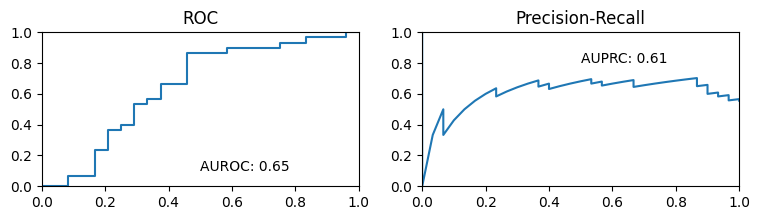

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(9, 2))
ax[0].plot(bench_loo['auroc']['fpr'], bench_loo['auroc']['tpr'])
ax[0].text(0.5, 0.1, f"AUROC: {round(bench_loo['auroc']['auroc'], 2)}")
ax[0].set_xlim((0, 1))
ax[0].set_ylim((0, 1))
ax[0].set_title("ROC")

ax[1].plot(bench_loo['auprc']['recall'], bench_loo['auprc']['precision'])
ax[1].text(0.5, 0.8, f"AUPRC: {round(bench_loo['auprc']['auprc'], 2)}")
ax[1].set_title("Precision-Recall")
ax[1].set_xlim((0, 1))
ax[1].set_ylim((0, 1))

Training data metrics

In [ ]:
bench['auroc']['auroc']

0.8458333333333334

In [ ]:
params = lr_model.sample(200)
loo_out = []
for batch in tqdm(iter(data_factory_factory(56)())):
    loo_out += [adaptive_is_loo(lr_model, batch, params, 0.5, variational=False)]

1it [00:07,  7.48s/it]


In [ ]:
loo_out[0].keys()

dict_keys(['I', 'KL', 'LL', 'Var'])

In [ ]:
khat = {}
p_loo = {}
for method in ["I", "LL", "KL", "Var"]:
    khat[method] = np.concatenate([out[method]["khat"] for out in loo_out], axis=0)
    p_loo[method] = np.concatenate([out[method]["p_loo"] for out in loo_out], axis=0)

In [ ]:
khat

{'I': array([ 0.11348391,  0.18814648,  0.24300765, -0.06333386,  0.06504264,
         0.17648114,  0.03084092, -0.05432084, -0.01952721, -0.04036441,
         0.00634301,  0.03525405,  0.03838298,  0.01810739,  0.22703645,
         0.19667928, -0.08501153,  0.02750508,  0.12937789,  0.08037288,
         0.1783023 ,  0.24261384,  0.2610867 , -0.16575349,  0.14528867,
         0.08339434,  0.07668309,  0.10663727,  0.01869823,  0.02074631,
         0.00188642,  0.19394075, -0.00722241,  0.105438  ,  0.33680465,
         0.08731662,  0.17237603,  0.02472222,  0.11994263,  0.12561871,
         0.19358071,  0.01917915,  0.16882212, -0.01847229,  0.01183301,
         0.18374762,  0.00288128, -0.00055553,  0.34408647, -0.05254772,
         0.14398786,  0.08158586,  0.24398044, -0.11207897]),
 'LL': array([ 0.1187946 ,  0.18641035,  0.28041759,  0.03729198,  0.15183568,
         0.24602849,  0.10075707, -0.10164519,  0.03871926, -0.04642655,
         0.10396005,  0.06665164,  0.05026228,  0.0

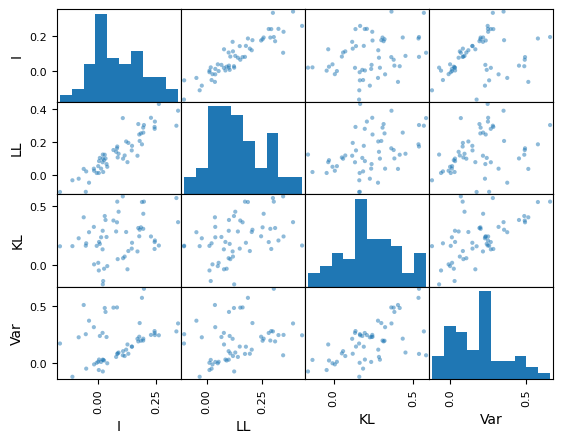

In [ ]:
khat = pd.DataFrame(khat)
_ = pd.plotting.scatter_matrix(khat)


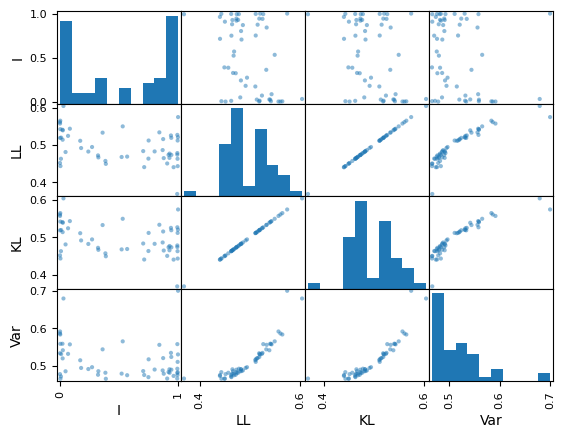

In [ ]:
p_loo = pd.DataFrame(p_loo)
_ = pd.plotting.scatter_matrix(p_loo)

In [ ]:
khat.describe()

,I,LL,KL,Var
count,54.000000,54.000000,54.000000,54.000000
mean,0.086149,0.141517,0.227480,0.191670
std,0.111618,0.124555,0.175247,0.174854
min,-0.165753,-0.102559,-0.162574,-0.118044
25%,0.007716,0.051194,0.135082,0.058154
50%,0.080979,0.121042,0.218704,0.195406
75%,0.175455,0.236233,0.323499,0.266915
max,0.344086,0.431153,0.583164,0.654444


In [ ]:
khat[khat.I > 0.5]

,I,LL,KL,Var


In [ ]:
(khat>0.5).describe()

,I,LL,KL,Var
count,54,54,54,54
unique,1,1,2,2
top,False,False,False,False
freq,54,54,49,51
